<a href="https://colab.research.google.com/github/jeromepatel/DL-University-Course-Practicals/blob/master/18BCE088_DL_practical_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Apr 12 06:11:40 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing Libraries

In [1]:

#importing libraries
from tensorflow.keras import datasets, utils, models, applications
from keras.datasets.mnist import load_data
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, LeakyReLU, Reshape
from keras.layers import Conv2D, MaxPool2D, BatchNormalization, Input
from keras import backend as K
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras import Input, Model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
import numpy as np
from tqdm import tqdm
batch_size = 128
num_classes = 10
epochs = 20


In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
(X_train, Y_train), (X_test, Y_test) = load_data()
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

## Defining Generator function 

In [4]:
def discriminator_model(input_shape = (28,28,1)):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),strides = (2,2),input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Conv2D(64,kernel_size = (3, 3),strides=(2,2)))
    # model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(LeakyReLU())
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(100,activation='relu'))
    model.add(Dropout(0.35))
    model.add(Dense(1,activation='sigmoid'))

    return model


def generator_model(input_dim = 100):
    ip_neurons = 256
    model = Sequential()
    model.add(Dense(7*7*ip_neurons,use_bias = False, input_dim = input_dim))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, ip_neurons)))
    model.add(layers.Conv2DTranspose(ip_neurons//2, (5, 5), strides=(1, 1), padding='same'))
    #at this point dimensions are 7 * 7 * 128 
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(layers.Conv2DTranspose(ip_neurons//4, (5, 5), strides=(2, 2), padding='same'))
    #dim becomes 14 * 14 * 64
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh'))
    #dimensions becomes equivalent to mnist image that is 28 * 28 * 1

    return model



CPU times: user 1.91 s, sys: 1.09 s, total: 3 s
Wall time: 32 s


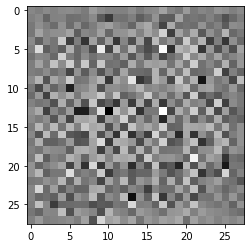

In [5]:
%%time
generator = generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


In [6]:
discriminator = discriminator_model()
output = discriminator(generated_image)
output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.5011638]], dtype=float32)>

In [8]:
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0
num_features = 100
# compile discriminator using binary cross entropy loss and adam optimizer
discriminator.compile(loss ="binary_crossentropy", optimizer ="adam")
# make  discriminator no-trainable as of  now
discriminator.trainable = False
# Combine both generator and discriminator
gan = keras.models.Sequential([generator, discriminator])
# compile generator using binary cross entropy loss and adam optimizer
  
gan.compile(loss ="binary_crossentropy", optimizer ="adam")

# code
batch_size = 32
# This dataset fills a buffer with buffer_size elements,
# then randomly samples elements from this buffer,
# replacing the selected elements with new elements.
def create_batch(x_train):
    dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
    # Combines consecutive elements of this dataset into batches.

    dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)
    # Creates a Dataset that prefetches elements from this dataset
    return dataset


# code
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training = False)

    fig = plt.figure(figsize =(10, 10))

    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap ='binary')
        plt.axis('off')

    plt.savefig('image_epoch_{:04d}.png'.format(epoch))



seed = tf.random.normal(shape =[batch_size, 100])

def train_dcgan(gan, dataset, batch_size, num_features, epochs = 5):
	generator, discriminator = gan.layers
	for epoch in tqdm(range(epochs)):
		print()
		print("Epoch {}/{}".format(epoch + 1, epochs))

		for X_batch in dataset:
			# create a random noise of sizebatch_size * 100
			# to passit into the generator
			noise = tf.random.normal(shape =[batch_size, num_features])
			generated_images = generator(noise)

			# take batch of generated image and real image and
			# use them to train the discriminator 
			X_fake_and_real = tf.concat([generated_images,tf.reshape(X_batch,generated_images.shape)], axis = 0)
			y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
			discriminator.trainable = True
			discriminator.train_on_batch(X_fake_and_real, y1)

			# Here we will be training our GAN model, in this step
			# we pass noise that uses geeneratortogenerate the image
			# and pass it with labels as [1] So, it can fool the discriminatoe
			noise = tf.random.normal(shape =[batch_size, num_features])
			y2 = tf.constant([[1.]] * batch_size)
			discriminator.trainable = False
			gan.train_on_batch(noise, y2)

			# generate images for the GIF as we go
			# generate_and_save_images(generator, epoch + 1, seed)

	# generate_and_save_images(generator, epochs, seed)


# reshape to add a color map
# x_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.
# create batches
dataset = create_batch(X_train)
# callthe training function with 10 epochs and record time %% time
train_dcgan(gan, dataset, batch_size, num_features, epochs = 10)



  0%|          | 0/10 [00:00<?, ?it/s]


Epoch 1/10



 10%|█         | 1/10 [00:47<07:04, 47.22s/it]


Epoch 2/10



 20%|██        | 2/10 [01:32<06:13, 46.73s/it]


Epoch 3/10



 30%|███       | 3/10 [02:19<05:26, 46.65s/it]


Epoch 4/10



 40%|████      | 4/10 [03:05<04:39, 46.57s/it]


Epoch 5/10



 50%|█████     | 5/10 [03:52<03:52, 46.51s/it]


Epoch 6/10



 60%|██████    | 6/10 [04:38<03:05, 46.44s/it]


Epoch 7/10



 70%|███████   | 7/10 [05:23<02:18, 46.18s/it]


Epoch 8/10



 80%|████████  | 8/10 [06:10<01:32, 46.29s/it]


Epoch 9/10



 90%|█████████ | 9/10 [06:56<00:46, 46.35s/it]


Epoch 10/10



100%|██████████| 10/10 [07:43<00:00, 46.33s/it]


In [17]:
# #make GAN using sequential gen, desc
# gan = keras.models.Sequential([generator, discriminator])
# discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
# discriminator.trainable = False
# gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

# gan.summary()
#combied network
# compile discriminator using binary cross entropy loss and adam optimizer
discriminator.compile(loss ="binary_crossentropy", optimizer ="adam")
random_dimension = 100

discriminator.trainable = False
random_gan_ip = Input(shape = (random_dimension,))
x = generator(random_gan_ip)
gan_op = discriminator(x)

gan = Model(inputs = random_gan_ip, outputs = gan_op)
gan.compile(loss = 'binary_crossentropy', optimizer = 'adam')
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         2331137   
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 249417    
Total params: 2,580,554
Trainable params: 2,305,665
Non-trainable params: 274,889
_________________________________________________________________


In [20]:

discriminative_loss = []
generative_loss = []

def plot_both_losses(iterations):
  plt.plot(discriminative_loss, label = 'Discriminative loss')
  plt.plot(generative_loss, label = 'Generative loss')
  plt.xlabel('No of iterations')
  plt.ylabel("Loss")
  plt.legend()
#plotting generated images

def plot_generated_images(iterations, examples = 100, dim = (10,10), figsize =  (10,10)):
  noise = np.random.normal(0,1,size = [examples, random_dimension])
  gen_image = generator.predict(noise)
  gen_image = gen_image.reshape(examples, 28,28)

  plt.figure(figsize=figsize)
  for i in range(gen_image.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(gen_image[i], interpolation = 'nearest', cmap = 'gray_r')
    plt.axis('off')
  plt.tight_layout()

def save_model(iterations):
  generator.save('models/gan_generator_epoch_%d.h5' % iteration)
  discriminator.save('models/gan_dicriminator_epoch_%d.h5' % iteration)


def train(iterations, batch_size):
  batch_count = X_train.shape[0] / batch_size
  print("Number of epochs = \t",iterations)
  print("Batch size = \t", batch_size)
  print("Batches per epoch = \t", batch_count)

  for i in range(1, iterations+1):
    print('\n\n','-'*15,'Epoch %d' % i, '-'*15)
    for _ in tqdm(range(int(batch_count))):
      noise = np.random.normal(0,1, size = [batch_size, random_dimension])
      image_batch = X_train[np.random.randint(0, X_train.shape[0], size = batch_size)]
      
      gen_image = generator.predict(noise)
    #   print(np.shape(image_batch))
    #   print(np.shape(gen_image))
      image_batch = image_batch.reshape(image_batch.shape[0], gen_image.shape[1],gen_image.shape[2],gen_image.shape[3])
      X = np.concatenate([image_batch, gen_image])

      yDis = np.zeros(2*batch_size)
      yDis[:batch_size] = 0.9

      discriminator.trainable = True
      d_loss = discriminator.train_on_batch(X, yDis)

      noise = np.random.normal(0,1,size = [batch_size, random_dimension])
      yGen = np.ones(batch_size)
      discriminator.trainable = False
      g_loss = gan.train_on_batch(noise, yGen)

    discriminative_loss.append(d_loss)
    generative_loss.append(g_loss)

    if i == 1 or i %20 == 0:
      plot_generated_images(i)

    plot_both_losses(i)

  0%|          | 0/468 [00:00<?, ?it/s]

Number of epochs = 	 2
Batch size = 	 128
Batches per epoch = 	 468.75


 --------------- Epoch 1 ---------------


  0%|          | 2/468 [00:00<00:33, 13.88it/s]



 --------------- Epoch 2 ---------------


100%|██████████| 468/468 [00:31<00:00, 15.01it/s]


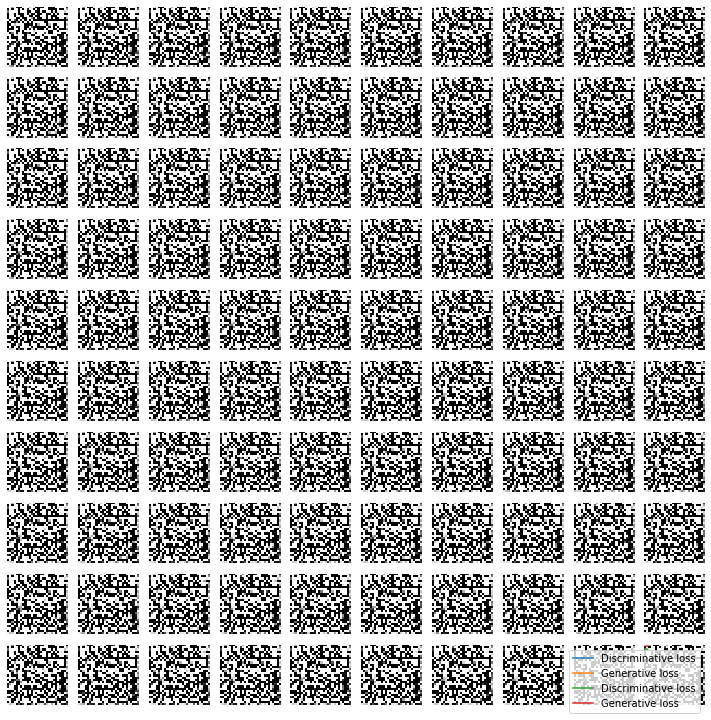

In [21]:
train(2,128)

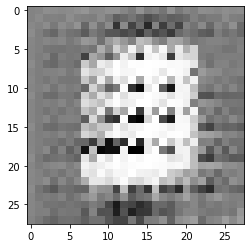

In [10]:

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


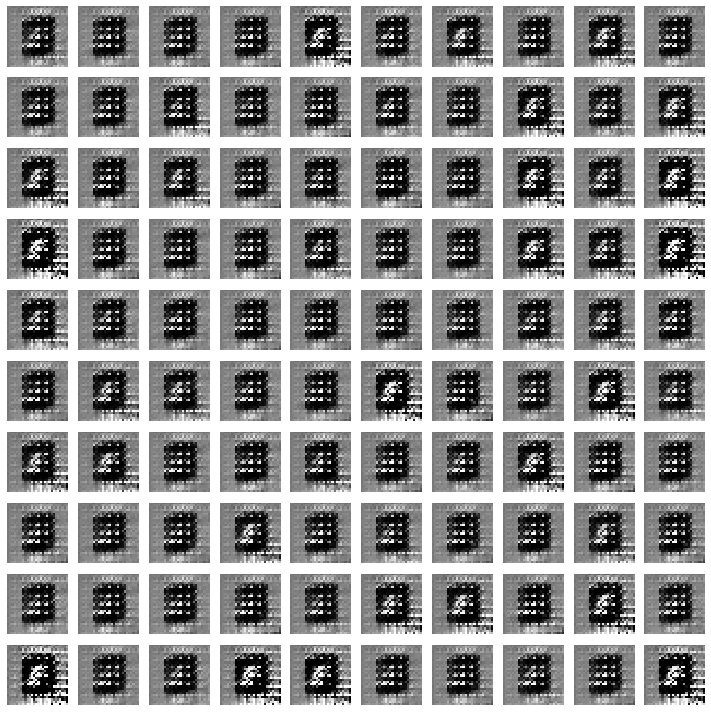

In [11]:
def plot_generated_images(iterations, examples = 100,random_dimension=100, dim = (10,10), figsize =  (10,10)):
  noise = np.random.normal(0,1,size = [examples, random_dimension])
  gen_image = generator.predict(noise)
  gen_image = gen_image.reshape(examples, 28,28)

  plt.figure(figsize=figsize)
  for i in range(gen_image.shape[0]):
    plt.subplot(dim[0], dim[1], i+1)
    plt.imshow(gen_image[i], interpolation = 'nearest', cmap = 'gray_r')
    plt.axis('off')
  plt.tight_layout()

plot_generated_images(1)